
# Personalized Melanoma Staging Model

The goal of this project is to create an easily understood and used tool for doctors to predict whether patients need a sentinel lymph node biopsy (SLNB). SLNB are an invasive procedure and currently doctors suggest it to patients if there is around a 10% chance for a positive biopsy. These odds are mostly based upon the depth of the melanoma, so I would like to use more data in order to create better predictions for the odds that patients need the biopsy. 

# The Data
I am using data from two sources: the National Cancer Database and the NIH's SEER Database. These have been combined into a single PostgreSQL table for faster query access.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import psycopg2 as sql

sql_mela = sql.connect(host="localhost", user="karenlarson", dbname="melanoma")
query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
            FROM melanoma"""

#query for matching JCO data            
query = """SELECT "AGE", "SEX", "DEPTH", "ULCERATION", "MITOSES", "CS_EXTENSION", "PRIMARY_SITE", "CS_LYMPH_NODE_METS"
           FROM melanoma
           WHERE ("DEPTH" <= 400 AND "DEPTH" >= 100)
           OR (("DEPTH" < 100 AND "DEPTH" >= 75) AND
           ("ULCERATION" >= 1 OR "MITOSES" >= 1 OR "AGE" < 40 )) OR 
           (("DEPTH" < 75 AND "DEPTH" >= 54) AND 
           (("MITOSES" >= 1 AND "ULCERATION" >= 1) OR ("ULCERATION" >= 1
           AND "AGE" < 40) OR ("MITOSES" >= 1 AND "AGE" < 40)));"""

In [2]:
mela = pd.read_sql_query(query, sql_mela)

In [3]:
mela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240886 entries, 0 to 240885
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AGE                 240886 non-null  int64  
 1   SEX                 240886 non-null  int64  
 2   DEPTH               240886 non-null  float64
 3   ULCERATION          240886 non-null  float64
 4   MITOSES             239829 non-null  float64
 5   CS_EXTENSION        240886 non-null  float64
 6   PRIMARY_SITE        240886 non-null  object 
 7   CS_LYMPH_NODE_METS  240886 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 14.7+ MB


As we can see, we have 860205 patients with originally 126 features (or attributes). Since it is a database, not all of these attributes would be known before a SLNB would be suggested and others of them would be irrelevant to the need for a biopsy. For example, <code>PUF_FACILITY_ID</code> (or the facility where these data were recorded) likely doesn't influence a patient's need for a biopsy. Using the SQL query, I have reduced this down to 7 key features, enumerated below:

- <code>AGE</code>: The age of the patient
- <code>SEX</code>: The sex of the patient
- <code>CS_SITESPECIFIC_FACTOR_1</code>: The depth of the tumor. I renamed this feature <code>DEPTH</code> to be more easily interpable
- <code>CS_SITESPECIFIC_FACTOR_2</code>: The formation of an ulcer on the skin. I renamed this feature <code>ULCERATION</code> to be more easily interpable
- <code>CS_EXTENSION</code>: Indicates the extent of the spread of the melanoma.
- <code>CS_SITESPECIFIC_FACTOR_7</code>: Categories for the number of mitoses per square mm around a "hot spot". I renamed this feature to <code>MITOSES</code> for interprability.
- <code>PRIMARY_SITE</code>: The main site for the melanoma. The options are:
    - <code>C44.0</code>: Skin of lips, NOS
    - <code>C44.1</code>: Eyelid
    - <code>C44.2</code>: External Ear
    - <code>C44.3</code>: Skin of other and unspecified parts of face
    - <code>C44.4</code>: Skin of scalp and neck
    - <code>C44.5</code>: Skin of the trunk
    - <code>C44.6</code>: Skin of upper limb and shoulder
    - <code>C44.7</code>: Skin of lower limb and hip
    - <code>C44.8</code>: Overlapping lesion of skin
    - <code>C44.9</code>: Skin, NOS
 
We are trying to calssify the patients into whether they had a positive lymph node biopsy or not. This is recorded in <code>CS_SITESPECIFIC_FACTOR_3</code>, here renamed as <code>CS_LYMPH_NODE_METS</code>.

# Data Cleaning

Some of the rows of the features are missing data and we also have a large number of medical codes that we want to reinterpret to make easier comparisons. This data cleaning is done using the <code>cleanData()</code> function. I used [this website](http://web2.facs.org/cstage0205/melanomaskin/MelanomaSkinschema.html) to understand the various medical encodings. The following steps are done for the data cleaning:

- I drop missing values (coded as 999, 1022, and NAN)
- I only look at melanoma coded as 1 <= <code>DEPTH</code> <= 980. Values recorded as 989 are relabeled as 980 (as they both encode tumors of size 9.80 mm or larger), and the other data labels are indicative of missing data. If the <code>DEPTH</code> is coded as 0, that means that no tumor mass was found, so those points are also excluded from consideration.
- I reincoded 990 as 0 and 991 as 1, as both of them represent a mitotic count (<code>MITOSES</code>), but are not specific in the exact mitotic rate. After, we only keep mitotic counts <= 11, as all other encodings represent missing data.
- For <code>ULCERATION</code>, I map 010 -> 001, as both of them represent that ulceration is present under the previous and current naming scheme. Then we only keep values equal to 1 or 0, as any other values represent missing data.
- <code>CS_EXTENSION</code> has data for both the Clark Level and for the staging information. The staging information is essentially already encoded in the <code>DEPTH</code> and <code>ULCERATION</code>, so we only want to focus on the Clark Level part (i.e. what level of the dermis has been invaded). We replace the codings that are not about the Clark Level with 999 and only keep the features that specify the Clark Level.
- <code>PRIMARY_SITE</code>, as mentioned above, encodes wehre the melanoma is located. I bin this into three categories: head (C44.0 - C44.4), trunk (C44.5), and limbs (C44.6 and C44.7). Since C44.8 and C44.9 do not give specific locations, these are dropped from consideration.
- <code>CS_LYMPH_NODE_METS</code> represents if the biopsy was positive or negative. The biopsy is only done if the lymph node metastasis is clinically occult (microscopic). The encodings that represent this are 000 and 005 for a negative biopsy and 001 and 010 for a positive biopsy. First, I recode 005 as 000 and 010 as 001, then I drop anything that has a value greater than 1.5.
- <code>SEX</code> and <code>AGE</code> did not have any missing data encodings, although patients 90 or older were binned into a single category.

After removing the missing data, we have a total of 194010 patients.

In [4]:
from cleanData import cleanData
X, y = cleanData(mela)

# Preparing Data for Training the Model

## Train/Validation/Test Split

I split the data into 70/10/20 Train/Valdiation/Test splits. We do this statified, as the data is skewed towards the negative class.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state=20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.125, stratify = y_train, random_state=20)

## Encoding the Attributes

I treat <code>SEX</code>, <code>ULCERATION</code>, and <code>PRIMARY_SITE</code> as categorical attributes. 

For the numeric attributes, I first apply a <code>MinMaxScaler</code> in order to have them all on approximately the same order. Next, I use <code>PolynomialFeatures</code> of flexible degree. I initially wanted to use polynomial features, because I though that something like melanoma volume could be an important feature, and looking at <code>DEPTH</code>^3 could be an approximation for the volume. Plus, there may be some very interesting unseen relationships between the various parameters that using simple linear regression would not notice.

The exact attribute encoding pipeline is included in "encodeAttribs.py".

I only fit the pipeline on <code>X_train</code> in order to avoid data leakage by training it on the entire set.

In [6]:
from encodeAttribs import preprocess_pipeline

num_attribs = ['AGE','DEPTH', "CS_EXTENSION", "MITOSES"]
cat_attribs = [ 'SEX', 'ULCERATION', 'PRIMARY_SITE']

pipe = preprocess_pipeline(num_attribs, 3, cat_attribs).fit(X_train)
x_train = pipe.transform(X_train)
x_cv = pipe.transform(X_cv)
x_test = pipe.transform(X_test)

# Model Evaluation (and Comparison)

The main model considered is logistic regression, but here are some other model comparisons that I considered as comparison to see if we could gain any additional gains from more complex models.

I wanted to work with logistic regression as it is highly interpretable and can be easily retrained if new data becomes available.

## Base Estimator
The Baseline is the current standard: all of the patients considered had a biopsy, but only a fraction of them had a positive biopsy. Here, my baseLine model predicts that every patient should have a biopsy, and achieves and accuracy of about 6.5%.

In [8]:
from baseLine import BaseLine
from sklearn.model_selection import cross_val_score
base_line_clf = BaseLine()
base_scores = cross_val_score(base_line_clf,x_train,y_train,cv=10,scoring="accuracy")
print(base_scores.mean())

0.06495988070919924


However, the main metrics that I care about are recall and specificity for this type of problem. I care about recall because we want as many patients who have sentinel lymph node metastasis to get tested for it. On the other hand, we also want to ensure that people who do not require a SLNB are not getting it. Specificity gives us a measure of this.

For the current method used by doctors (e.g. suggesting treatment when patients are at various cancer stages), the recall is 1.00, and the specificity is 0.00 for the data I'm considering.

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from classifierEvaluation import classifierEvaluation

log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(x_train,y_train);

In [10]:
importance = log_clf.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -1.46480
Feature: 1, Score: -1.71269
Feature: 2, Score: 8.84107
Feature: 3, Score: 6.30282
Feature: 4, Score: 5.70974
Feature: 5, Score: 0.06764
Feature: 6, Score: 2.23637
Feature: 7, Score: 1.67647
Feature: 8, Score: 0.93395
Feature: 9, Score: -7.66411
Feature: 10, Score: -2.86992
Feature: 11, Score: -5.45112
Feature: 12, Score: -1.50302
Feature: 13, Score: -1.92034
Feature: 14, Score: -5.80731
Feature: 15, Score: -1.28170
Feature: 16, Score: -0.14427
Feature: 17, Score: 0.25535
Feature: 18, Score: -0.78636
Feature: 19, Score: -0.80545
Feature: 20, Score: -2.05539
Feature: 21, Score: -0.49739
Feature: 22, Score: -1.22498
Feature: 23, Score: -1.01883
Feature: 24, Score: -0.23311
Feature: 25, Score: 1.42005
Feature: 26, Score: 1.46672
Feature: 27, Score: 3.21673
Feature: 28, Score: -1.73818
Feature: 29, Score: 1.85404
Feature: 30, Score: 0.23025
Feature: 31, Score: -1.47989
Feature: 32, Score: 0.57936
Feature: 33, Score: 0.79382
Feature: 34, Score: 2.62924
Feature: 35

For the Training Data using Logistic Regression, the accuracy is 0.2235, the precision is 0.0770, the recall is 0.9967, the specificity is 0.1698, the f1 score is 0.1429, the auc is 0.8505
[[ 21556 105429]
 [    29   8793]]


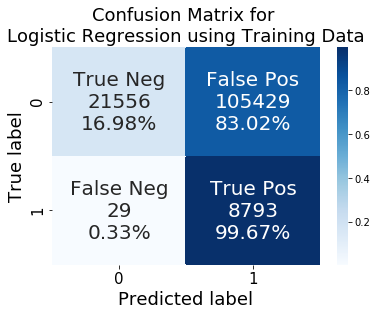

For the Validation Data using Logistic Regression, the accuracy is 0.2233, the precision is 0.0771, the recall is 0.9984, the specificity is 0.1695, the f1 score is 0.1431, the auc is 0.8491
[[ 3074 15067]
 [    2  1258]]


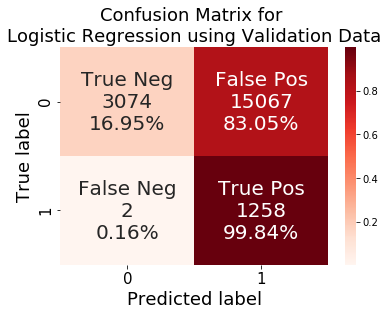

For the Test Data using Logistic Regression, the accuracy is 0.2218, the precision is 0.0767, the recall is 0.9952, the specificity is 0.1681, the f1 score is 0.1425, the auc is 0.8421
[[ 6098 30183]
 [   12  2509]]


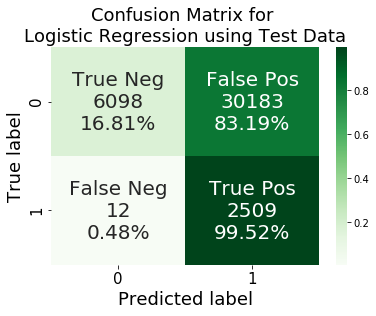

In [11]:
classifierEvaluation(log_clf, 0.005, x_train, y_train, "Logistic Regression", "Training Data")
classifierEvaluation(log_clf, 0.005, x_cv, y_cv, "Logistic Regression", "Validation Data")
classifierEvaluation(log_clf, 0.005, x_test, y_test, "Logistic Regression", "Test Data")

## Decision Trees

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42, max_depth = 7, class_weight='balanced')
tree.fit(x_train, y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

For the Training Data using Decision Tree, the accuracy is 0.2592, the precision is 0.0804, the recall is 0.9969, the specificity is 0.2080, the f1 score is 0.1488, the auc is 0.8620
[[ 26409 100576]
 [    27   8795]]


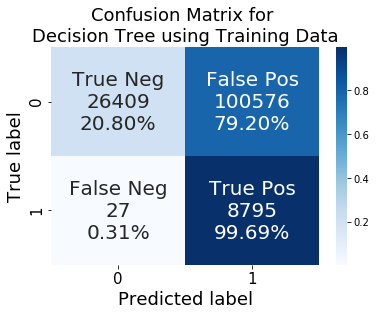

For the Validation Data using Decision Tree, the accuracy is 0.2588, the precision is 0.0801, the recall is 0.9929, the specificity is 0.2078, the f1 score is 0.1482, the auc is 0.8491
[[ 3770 14371]
 [    9  1251]]


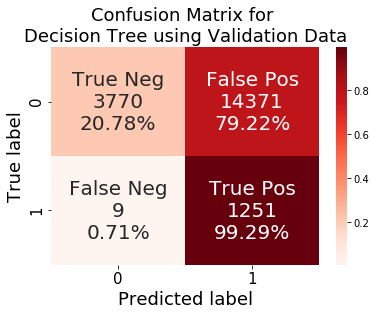

For the Test Data using Decision Tree, the accuracy is 0.2568, the precision is 0.0797, the recall is 0.9905, the specificity is 0.2058, the f1 score is 0.1476, the auc is 0.8406
[[ 7466 28815]
 [   24  2497]]


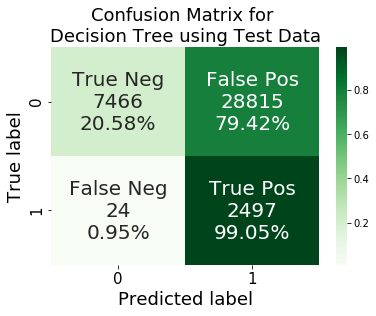

In [13]:
classifierEvaluation(tree, 0.03, x_train, y_train, "Decision Tree", "Training Data")
classifierEvaluation(tree, 0.03, x_cv, y_cv, "Decision Tree", "Validation Data")
classifierEvaluation(tree, 0.03, x_test, y_test, "Decision Tree", "Test Data")

In [34]:
from sklearn.ensemble import RandomForestClassifier

depth = [9, 10, 11, 12,]
#threshold = [0.001, 0.002, 0.0025, 0.003, 0.004, 0.005]
threshold = [0.025, 0.03, 0.04, 0.05]
for d in depth:
    forest = RandomForestClassifier(max_depth = d,random_state=42, class_weight='balanced')
    forest.fit(x_train,y_train)
    for thresh in threshold:
        print(f"THE THRESHOLD IS {thresh} AND FOREST DEPTH IS {d}!")
        classifierEvaluation(forest, thresh, x_train, y_train, "Random Forest", "Training Data")
        classifierEvaluation(forest, thresh, x_cv, y_cv, "Random Forest", "Validation Data")
    #classifierEvaluation(forest, thresh, x_test, y_test, "Random Forest", "Test Data")


In [48]:
forest = RandomForestClassifier(max_depth = 10,random_state=42)
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

For the Training Data using Random Forest, the accuracy is 0.3255, the precision is 0.0877, the recall is 0.9976, the specificity is 0.2788, the f1 score is 0.1612, the auc is 0.8979
[[35398 91587]
 [   21  8801]]


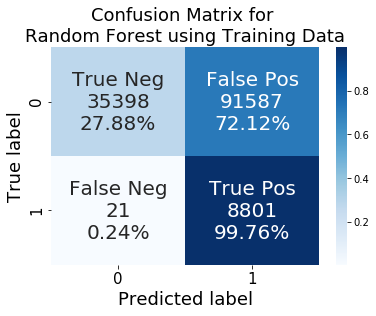

For the Validation Data using Random Forest, the accuracy is 0.3257, the precision is 0.0875, the recall is 0.9952, the specificity is 0.2791, the f1 score is 0.1609, the auc is 0.8618
[[ 5064 13077]
 [    6  1254]]


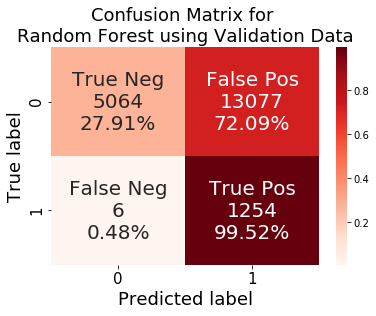

In [44]:
thresh = 0.03
#print(f"THE THRESHOLD IS {thresh} AND FOREST DEPTH IS {d}!")
classifierEvaluation(forest, thresh, x_train, y_train, "Random Forest", "Training Data")
classifierEvaluation(forest, thresh, x_cv, y_cv, "Random Forest", "Validation Data")
#classifierEvaluation(forest, thresh, x_test, y_test, "Random Forest", "Test Data")

# Random Search Set-up

In [35]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'max_features': max_features,
               'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint(random_grid)


{'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [200, 400, 600, 800]}


# Test One: Grid Search on Linear Features

In [36]:
pipe = preprocess_pipeline(num_attribs, 1, cat_attribs).fit(X_train)
x_train = pipe.transform(X_train)
x_cv = pipe.transform(X_cv)
x_test = pipe.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_1.fit(x_train, y_train)

/Users/karenlarson/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [ ]:
rf_random_1.best_params_

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import recall_score
def evaluate(base_model, X, y, thresh):
    y_pred = np.where(base_model.predict_proba(X)[:,1] > thresh, 1, 0)
    cf_mat = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cf_mat.ravel()
    return recall_score(y, y_pred),  tn/(tn + fp)
    
thresh = 0.03
base_model_1 = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model_1.fit(x_train, y_train)
base_recall, base_specificity = evaluate(base_model_1, x_cv, y_cv, thresh)

best_random = rf_random.best_estimator_
best_recall, best_specificity = evaluate(best_random_1, x_cv, y_cv, thresh)


print('Improvement of {:0.2f}%.'.format( 100 * (best_recall - base_recall) / base_recall))
print('Improvement of {:0.2f}%.'.format( 100 * (best_specificity - base_specificity) / base_specificity))

In [ ]:
print(best_recall, best_specificity)

# Test Two: Grid Search on Quartic Features

In [ ]:
pipe = preprocess_pipeline(num_attribs, 2, cat_attribs).fit(X_train)
x_train = pipe.transform(X_train)
x_cv = pipe.transform(X_cv)
x_test = pipe.transform(X_test)

In [ ]:
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_2.fit(x_train, y_train)

In [ ]:
thresh = 0.03
base_model_2 = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model_2.fit(x_train, y_train)
base_recall, base_specificity = evaluate(base_model_2, x_cv, y_cv, thresh)

best_random_2 = rf_random.best_estimator_
best_recall, best_specificity = evaluate(best_random_2, x_cv, y_cv, thresh)


print('Improvement of {:0.2f}%.'.format( 100 * (best_recall - base_recall) / base_recall))
print('Improvement of {:0.2f}%.'.format( 100 * (best_specificity - base_specificity) / base_specificity))

In [ ]:
rf_random_2.best_params_

# Test Three: Grid Search on Degree 3 Features


In [ ]:
pipe = preprocess_pipeline(num_attribs, 3, cat_attribs).fit(X_train)
x_train = pipe.transform(X_train)
x_cv = pipe.transform(X_cv)
x_test = pipe.transform(X_test)

In [ ]:
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_3 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_3.fit(x_train, y_train)

In [ ]:
thresh = 0.03
base_model_3 = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model_3.fit(x_train, y_train)
base_recall, base_specificity = evaluate(base_model_3, x_cv, y_cv, thresh)

best_random_3 = rf_random_3.best_estimator_
best_recall, best_specificity = evaluate(best_random_3, x_cv, y_cv, thresh)


print('Improvement of {:0.2f}%.'.format( 100 * (best_recall - base_recall) / base_recall))
print('Improvement of {:0.2f}%.'.format( 100 * (best_specificity - base_specificity) / base_specificity))

In [33]:
rf_random_3.best_params_

{'n_estimators': 200,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

# Splitting on strata

In [45]:
from splitStrata import splitStrata

T1a, y1a, T1b, y1b, T2a, y2a, T2b, y2b, T3a, y3a, T3b, y3b, T4a, y4a, T4b, y4b = splitStrata(X_cv, y_cv)

In [46]:
x_t1a = pipe.transform(T1a)
x_t1b = pipe.transform(T1b)

x_t2a = pipe.transform(T2a)
x_t2b = pipe.transform(T2b)

x_t3a = pipe.transform(T3a)
x_t3b = pipe.transform(T3b)

x_t4a = pipe.transform(T4a)
x_t4b = pipe.transform(T4b)

For the T1a Val Data using Random Forest, the accuracy is 0.8820, the precision is 0.0212, the recall is 0.6364, the specificity is 0.8829, the f1 score is 0.0410, the auc is 0.8243
[[7324  971]
 [  12   21]]


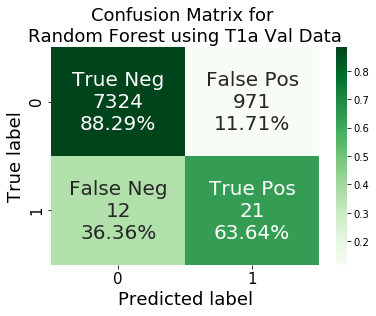

For the T1b Val Data using Random Forest, the accuracy is 0.8163, the precision is 0.1117, the recall is 0.5032, the specificity is 0.8297, the f1 score is 0.1829, the auc is 0.7619
[[3020  620]
 [  77   78]]


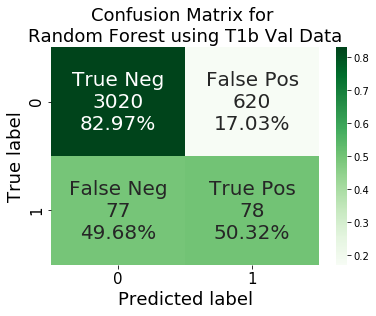

For the T2a Val Data using Random Forest, the accuracy is 0.3880, the precision is 0.1252, the recall is 0.8797, the specificity is 0.3348, the f1 score is 0.2193, the auc is 0.6897
[[ 900 1788]
 [  35  256]]


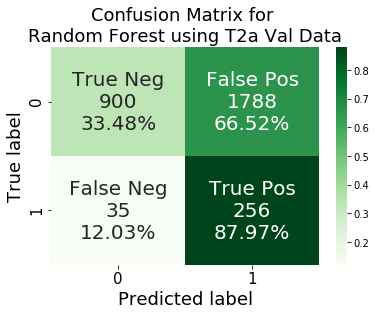

For the T2b Val Data using Random Forest, the accuracy is 0.2774, the precision is 0.1459, the recall is 0.9881, the specificity is 0.1763, the f1 score is 0.2542, the auc is 0.7169
[[104 486]
 [  1  83]]


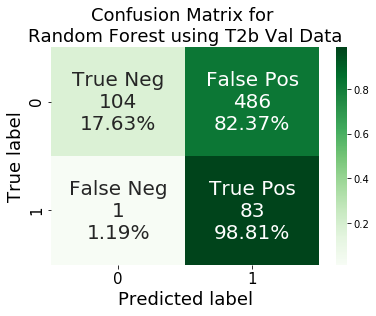

For the T3a Val Data using Random Forest, the accuracy is 0.1902, the precision is 0.1578, the recall is 0.9948, the specificity is 0.0456, the f1 score is 0.2723, the auc is 0.6912
[[  49 1025]
 [   1  192]]


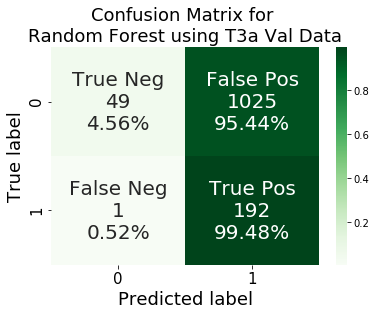

For the T3b Val Data using Random Forest, the accuracy is 0.2254, the precision is 0.2093, the recall is 0.9947, the specificity is 0.0259, the f1 score is 0.3458, the auc is 0.6902
[[ 19 714]
 [  1 189]]


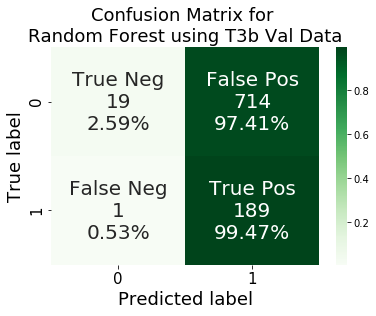

For the T4a Val Data using Random Forest, the accuracy is 0.3084, the precision is 0.2736, the recall is 1.0000, the specificity is 0.0648, the f1 score is 0.4297, the auc is 0.7172
[[ 41 592]
 [  0 223]]


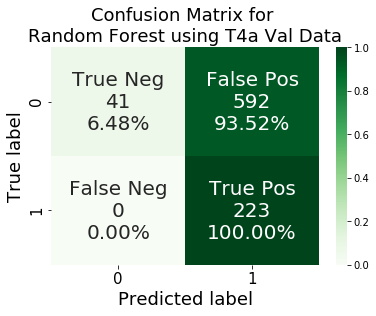

For the T4b Val Data using Random Forest, the accuracy is 0.2038, the precision is 0.1649, the recall is 1.0000, the specificity is 0.0553, the f1 score is 0.2830, the auc is 0.6633
[[ 27 461]
 [  0  91]]


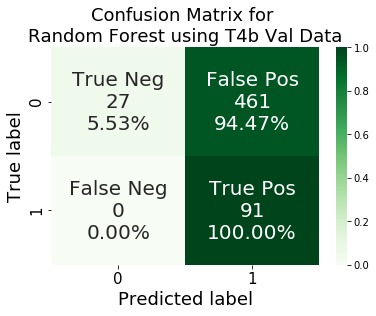

In [66]:
thresh = 0.025

classifierEvaluation(forest, 0.01, x_t1a, y1a, "Random Forest", "T1a Val Data")
classifierEvaluation(forest, 0.06, x_t1b, y1b, "Random Forest", "T1b Val Data")

classifierEvaluation(forest, 0.06, x_t2a, y2a, "Random Forest", "T2a Val Data")
classifierEvaluation(forest, 0.05, x_t2b, y2b, "Random Forest", "T2b Val Data")

classifierEvaluation(forest, 0.05, x_t3a, y3a, "Random Forest", "T3a Val Data")
classifierEvaluation(forest, 0.05, x_t3b, y3b, "Random Forest", "T3b Val Data")

classifierEvaluation(forest, 0.08, x_t4a, y4a, "Random Forest", "T4a Val Data")
classifierEvaluation(forest, 0.06, x_t4b, y4b, "Random Forest", "T4b Val Data")

In [ ]:
#T1a, y1a, T1b, y1b, T2a, y2a, T2b, y2b, T3a, y3a, T3b, y3b, T4a, y4a, T4b, y4b = splitStrata(X_train, y_train)
#x_t1a = pipe.transform(T1a)
#x_t1b = pipe.transform(T1b)
#
#x_t2a = pipe.transform(T2a)
#x_t2b = pipe.transform(T2b)
#
#x_t3a = pipe.transform(T3a)
#x_t3b = pipe.transform(T3b)
#
#x_t4a = pipe.transform(T4a)
#x_t4b = pipe.transform(T4b)

In [ ]:
#thresh = 0.05
#
#classifierEvaluation(forest, 0.04, x_t1a, y1a, "Random Forest", "T1a Training Data")
#classifierEvaluation(forest, 0.05, x_t1b, y1b, "Random Forest", "T1b Training Data")
#
#classifierEvaluation(forest, 0.15, x_t2a, y2a, "Random Forest", "T2a Training Data")
#classifierEvaluation(forest, 0.15, x_t2b, y2b, "Random Forest", "T2b Training Data")
#
#classifierEvaluation(forest, 0.15, x_t3a, y3a, "Random Forest", "T3a Training Data")
#classifierEvaluation(forest, 0.20, x_t3b, y3b, "Random Forest", "T3b Training Data")
#
#classifierEvaluation(forest, 0.25, x_t4a, y4a, "Random Forest", "T4a Training Data")
#classifierEvaluation(forest, 0.25, x_t4b, y4b, "Random Forest", "T4b Training Data")

In [ ]:
#T1a, y1a, T1b, y1b, T2a, y2a, T2b, y2b, T3a, y3a, T3b, y3b, T4a, y4a, T4b, y4b = splitStrata(X_test, y_test)
#x_t1a = pipe.transform(T1a)
#x_t1b = pipe.transform(T1b)
#
#x_t2a = pipe.transform(T2a)
#x_t2b = pipe.transform(T2b)
#
#x_t3a = pipe.transform(T3a)
#x_t3b = pipe.transform(T3b)
#
#x_t4a = pipe.transform(T4a)
#x_t4b = pipe.transform(T4b)

In [ ]:
#thresh = 0.05
#
#classifierEvaluation(forest, 0.04, x_t1a, y1a, "Random Forest", "T1a Test Data")
#classifierEvaluation(forest, 0.05, x_t1b, y1b, "Random Forest", "T1b Test Data")
#
#classifierEvaluation(forest, 0.15, x_t2a, y2a, "Random Forest", "T2a Test Data")
#classifierEvaluation(forest, 0.15, x_t2b, y2b, "Random Forest", "T2b Test Data")
#
#classifierEvaluation(forest, 0.15, x_t3a, y3a, "Random Forest", "T3a Test Data")
#classifierEvaluation(forest, 0.20, x_t3b, y3b, "Random Forest", "T3b Test Data")
#
#classifierEvaluation(forest, 0.25, x_t4a, y4a, "Random Forest", "T4a Test Data")
#classifierEvaluation(forest, 0.25, x_t4b, y4b, "Random Forest", "T4b Test Data")